# Practical Machine Learning for Physicists

In this notebook we will illustrate the Markov Chain Monte Carlo technique using an example from physics, a lattice of spin states.

## Spin and the Ising Model

In the slides we saw that the energy in a spin model when $s_i \in \{-1,+1\}$ was given by:
$$ E(s) = - \sum_i a_i s_i - \sum_{i,j} J s_i s_j $$
where the $a_i$ describes the interactions with an external field and the $J$ terms are the self interaction.

If we ignore the external field contribution and limit the spin-interaction to the nearest neighbours (up-down-left-right on a 2D lattice) then the energy function becomes:
$$ E(s) = - \sum_{ij,nn} J s_i s_j $$

To mimic a large areas we can use periodic bundary conditions (so the right-hand side of the right edge is the left edge).

## Magnetisation

The degree of magnetisation can be characterised as
$$ M = \frac{1}{N} \sum_{i=1}^N s_i $$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display
from tqdm import tqdm

In [13]:
Nx=Ny=30
def init_spins():  #Get initial random spin state
    spins=np.random.random((Nx,Ny))  # Get random spins
    spins=spins>0.5  
    spins=2*(spins-0.5)  #Convert 0-1. to -1 or 1
    return spins

## Plot the spins
Here we define a function to plot the spins (does it look familiar from Week 7?)

In [3]:
#Plot the array of -1,+1 spin values as unicode up down arrows.
def plotSpins(spinVals,title=None):
    fig, ax = plt.subplots(figsize=(2,2))
    ax.axis('tight')
    ax.axis('off')
    nRow=spinVals.shape[0]
    nCol=spinVals.shape[1]
    arrows='⇩⇧'
    spinArrow=[[ arrows[int(val>0)] for val in row ] for row in spinVals ]
    
    the_table = ax.table(spinArrow,loc='center',cellLoc='center')
    for pos, cell in the_table._cells.items():     
        cell._height = cell._width = 1./nRow
    if title:
        ax.set_title(title)

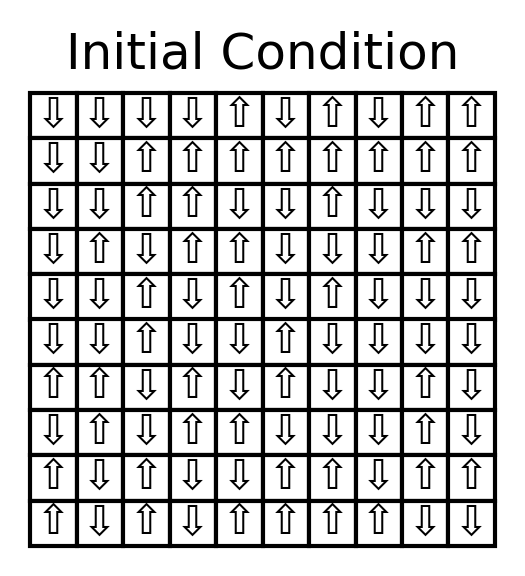

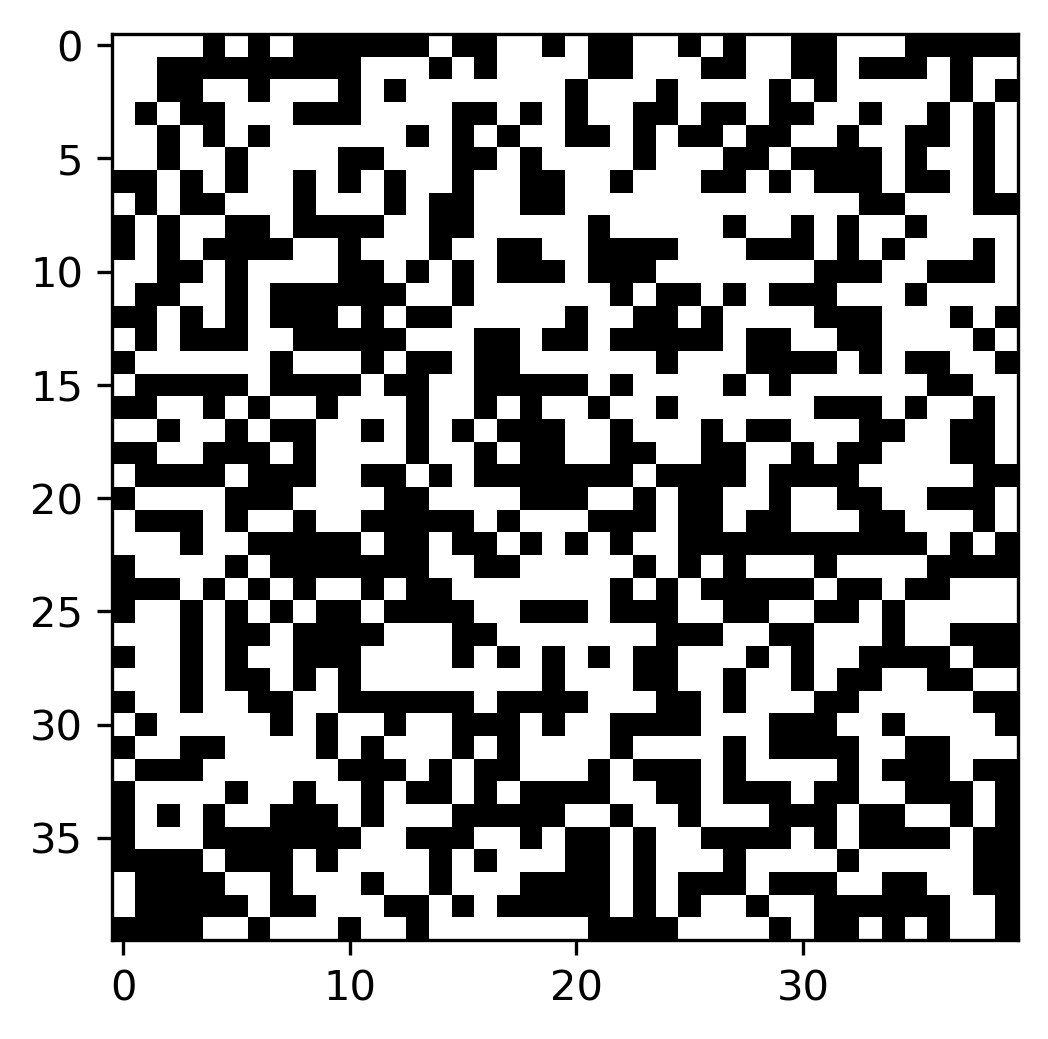

In [4]:
spins=init_spins()
plotSpins(spins[0:10,0:10],title="Initial Condition")  #Only plot a 10x10 square as it gets too crowded otherwise
fig,ax=plt.subplots()
ax.imshow(spins,cmap='binary')

In [5]:
# Calculate the total energy in the spin array using
# E = sum ( - J s_i s_j)
# where the sum is only over the nearest neighbours (up, down and left, right)
# using periodic boundary conditions on the 2-D grid.
# Inputs: spinarray, 2-D array of spins (-1 or +1)
#  J is energy of each spin interaction 
# Return: Total energy
def get_energy(spinarray,J):
    middle = spinarray
    up   = np.roll(spinarray,+1,axis=0)  # array shift along axis=0
    right= np.roll(spinarray,+1,axis=1)  # array shift along axis=1
    total = np.sum((up + right)*middle) 
    return -J*total #total energy

print("Energy: ",get_energy(spins,1))

Energy:  36.0


## The Metropolis-Hastings Algorithm

The Metropolis-Hastings algorithm is:
1. Pick a random point in the grid
2. Compute the energy difference in the spin in that location is flipped, $dE$
3. If $dE<0$ flip the spin, otherwise randomly flip the spin with probability $p(dE) = e^{- \beta dE}$ where $\beta=\frac{1}{k_{B}T}$

In [6]:
def mcmh_step(spins,E1,T,J):
    ij=np.random.randint(Nx,size=(2))
    i=ij[0]
    j=ij[1]
    sij=spins[i][j]
    spins[i][j]=-1*sij
    E2=get_energy(spins,J)
    dE=E2-E1
    if dE < 0:
        return spins,E2
    if np.random.random(1)<np.exp(-dE/T):
        return spins,E2
    spins[i][j]=sij
    return spins,E1
    

In [7]:
spins=init_spins()
T=0.5
J=1
steps=100000
energy=get_energy(spins,J)
energies=np.zeros(steps)
mags=np.zeros(steps)
for step in range(steps):
    spins,energy=mcmh_step(spins,energy,T, J)
    energies[step]=energy
    mags[step]=np.average(spins)

Text(0.5, 1.0, 'Magnetisation at T=0.5')

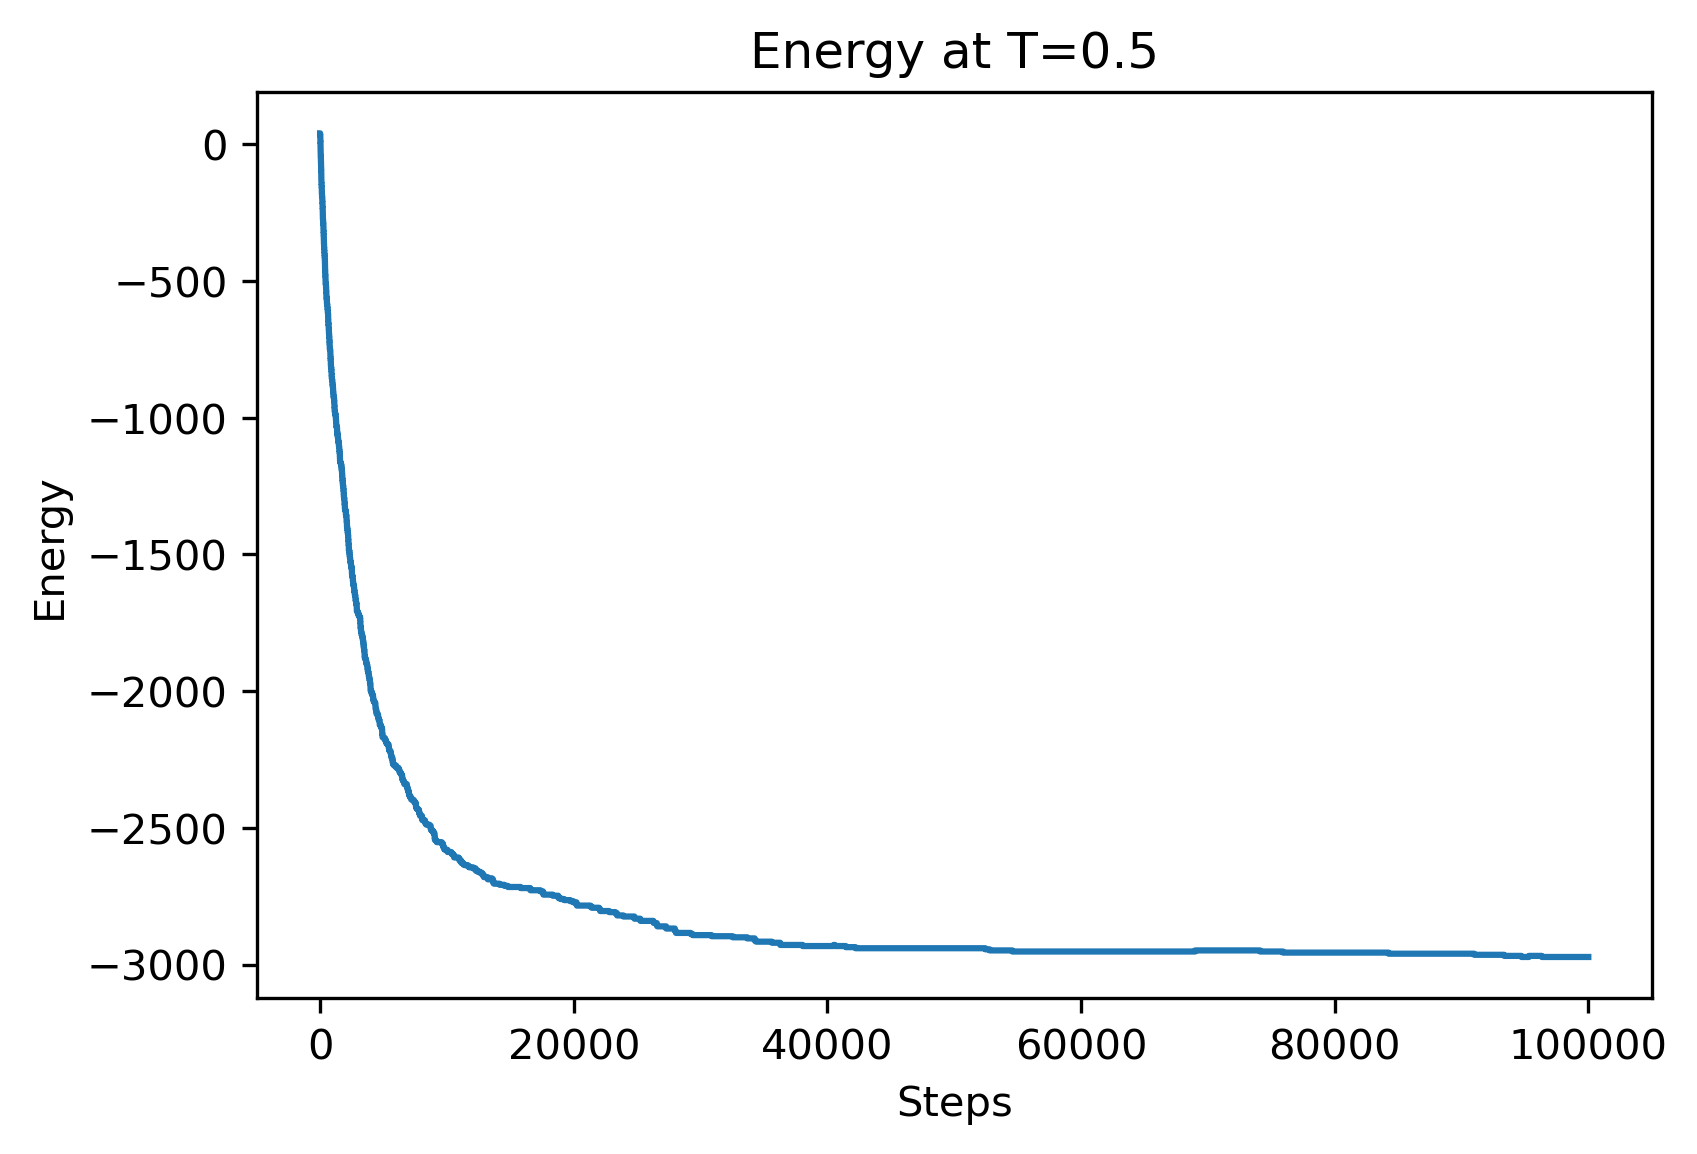

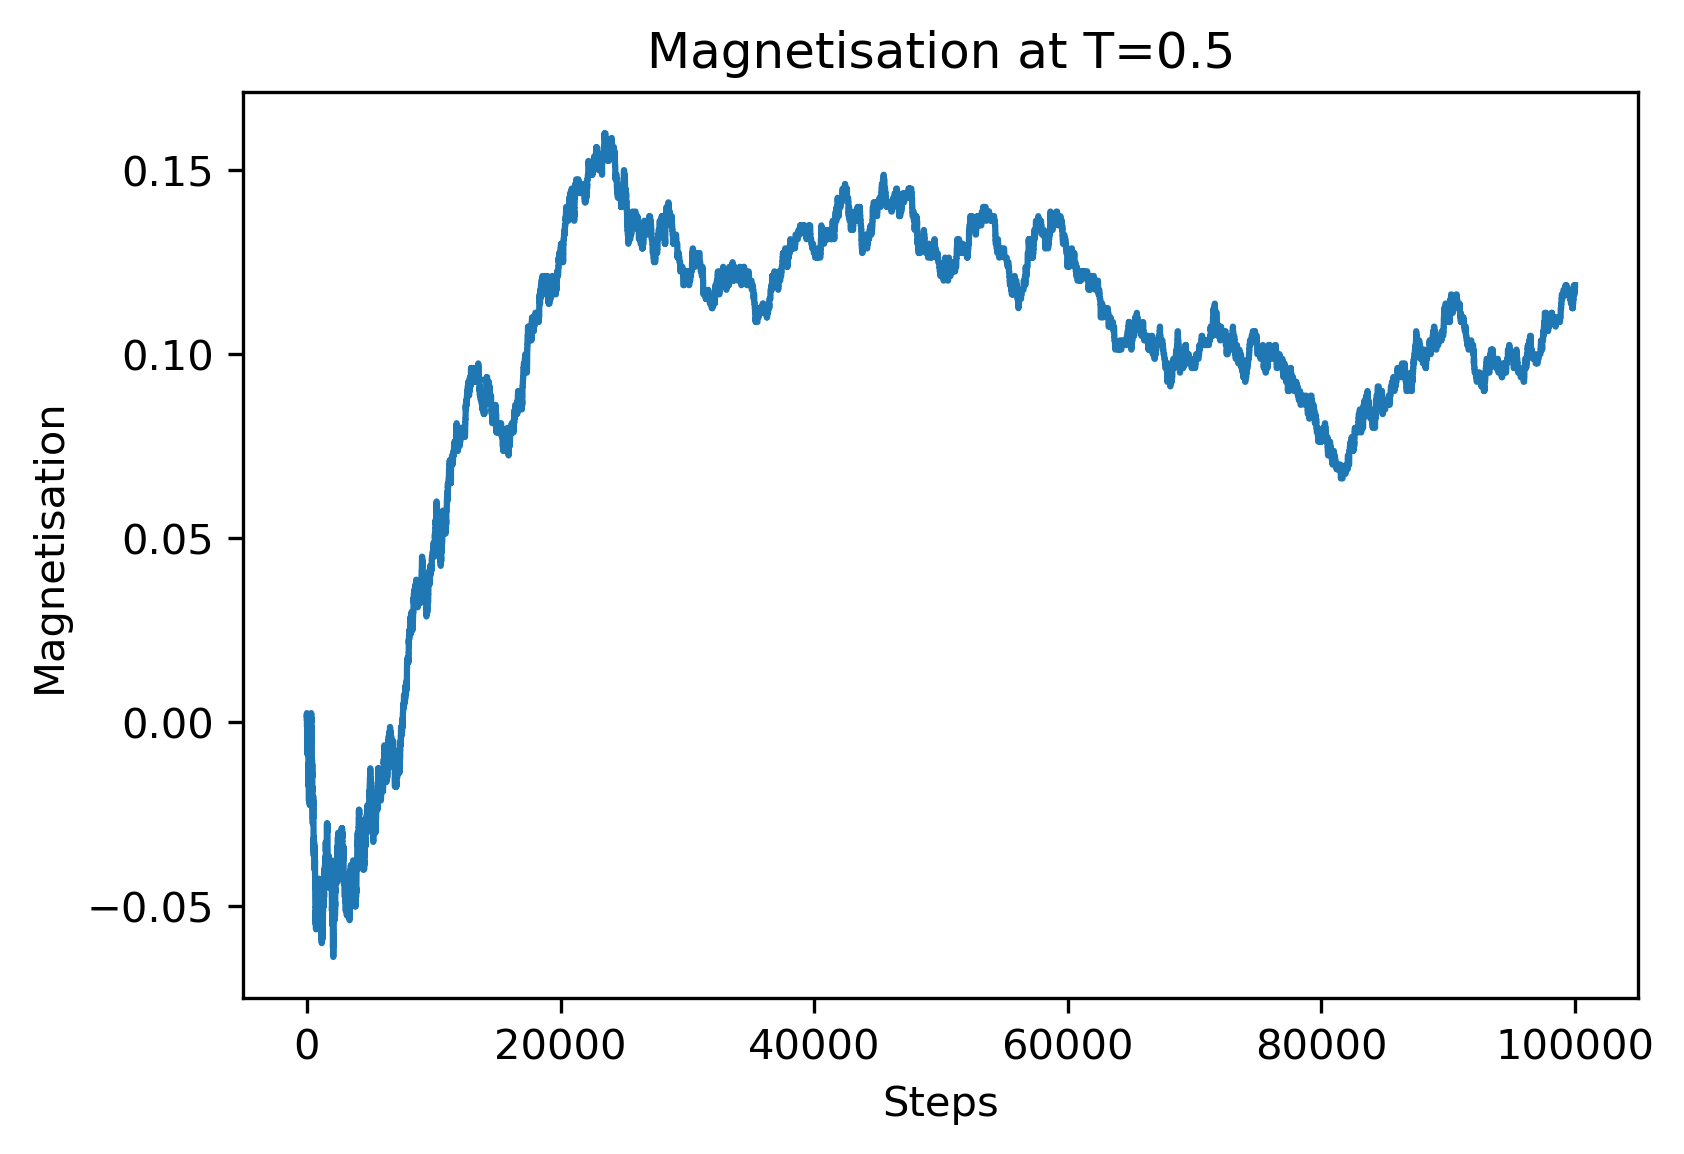

In [8]:
fig,ax=plt.subplots()
ax.plot(np.arange(steps),energies)
ax.set_xlabel("Steps")
ax.set_ylabel("Energy")
ax.set_title("Energy at T="+str(T))

fig,ax=plt.subplots()
ax.plot(np.arange(steps),mags)
ax.set_xlabel("Steps")
ax.set_ylabel("Magnetisation")
ax.set_title("Magnetisation at T="+str(T))

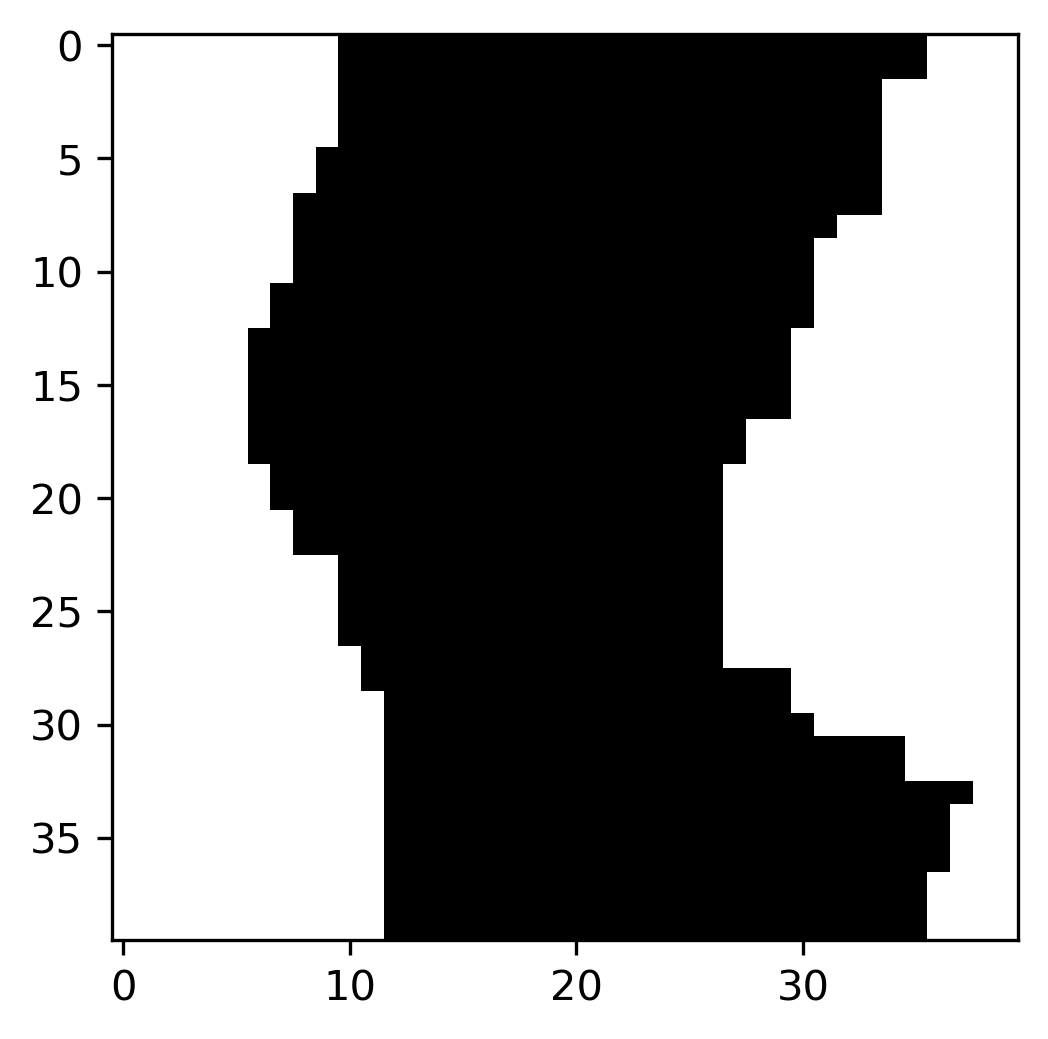

In [9]:
fig,ax=plt.subplots()
ax.imshow(spins,cmap='binary')

100%|██████████| 10/10 [01:19<00:00,  7.94s/it]


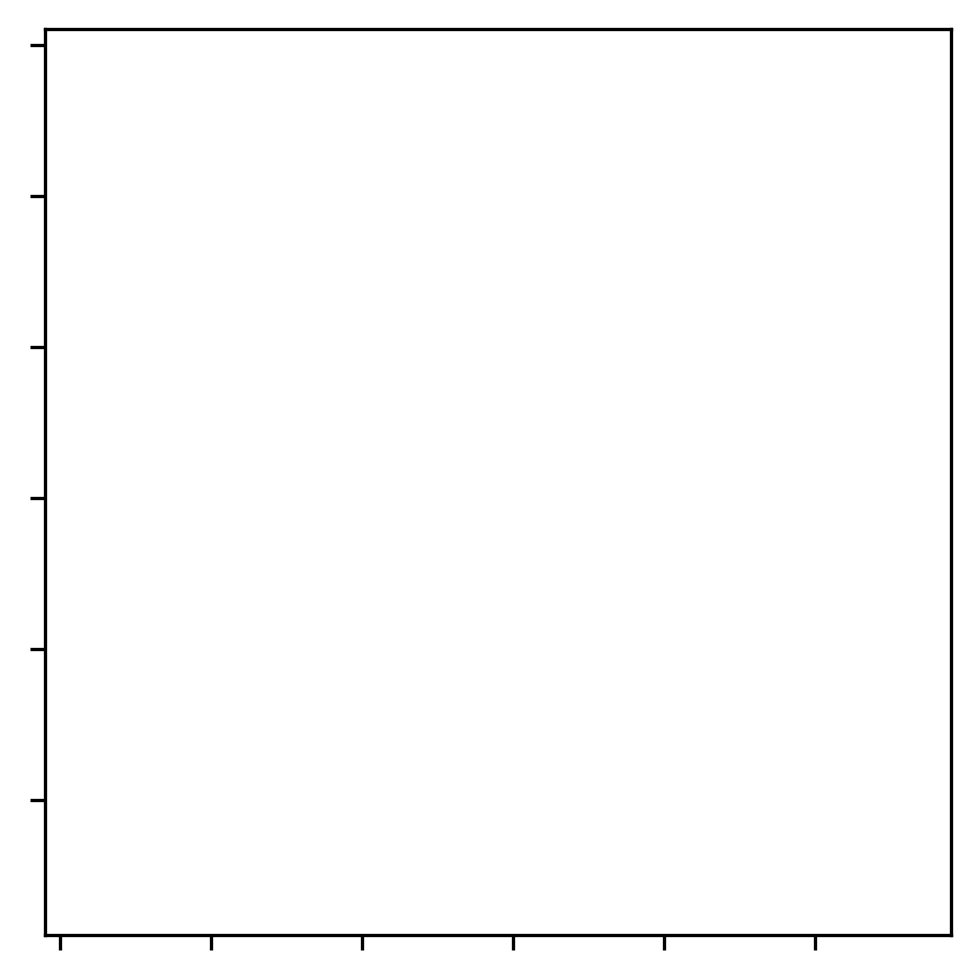

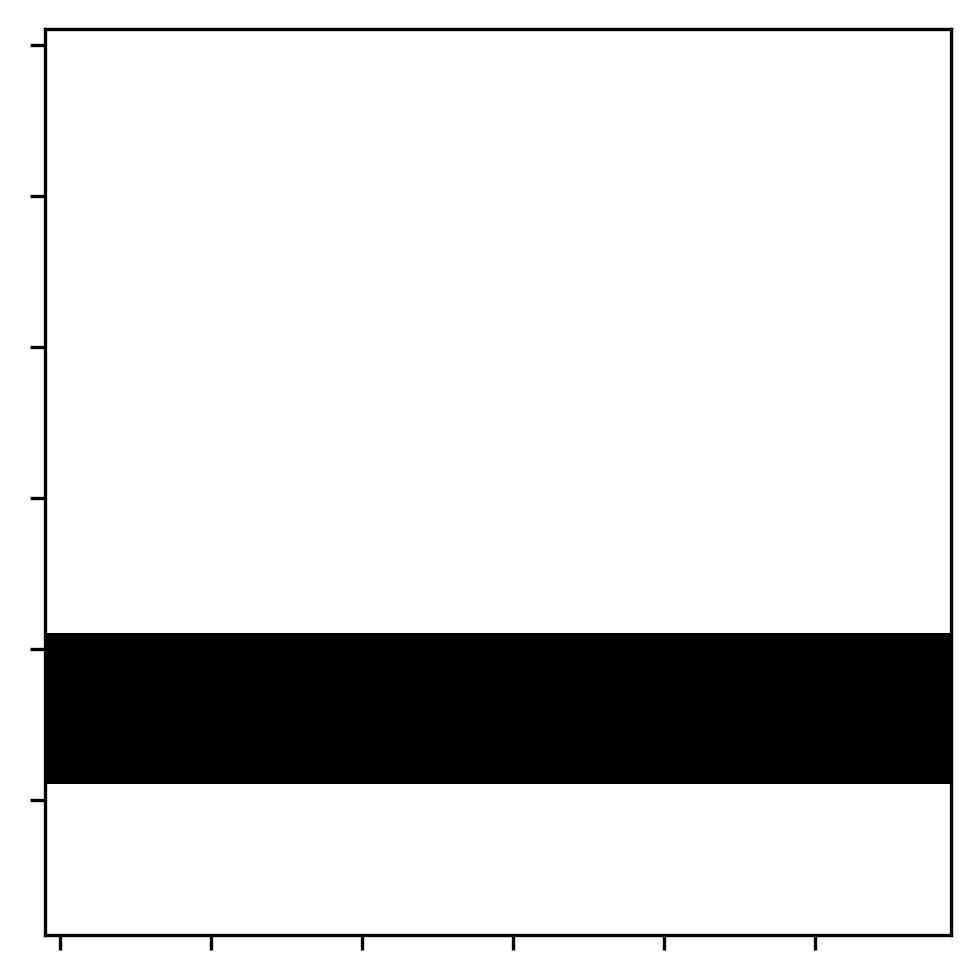

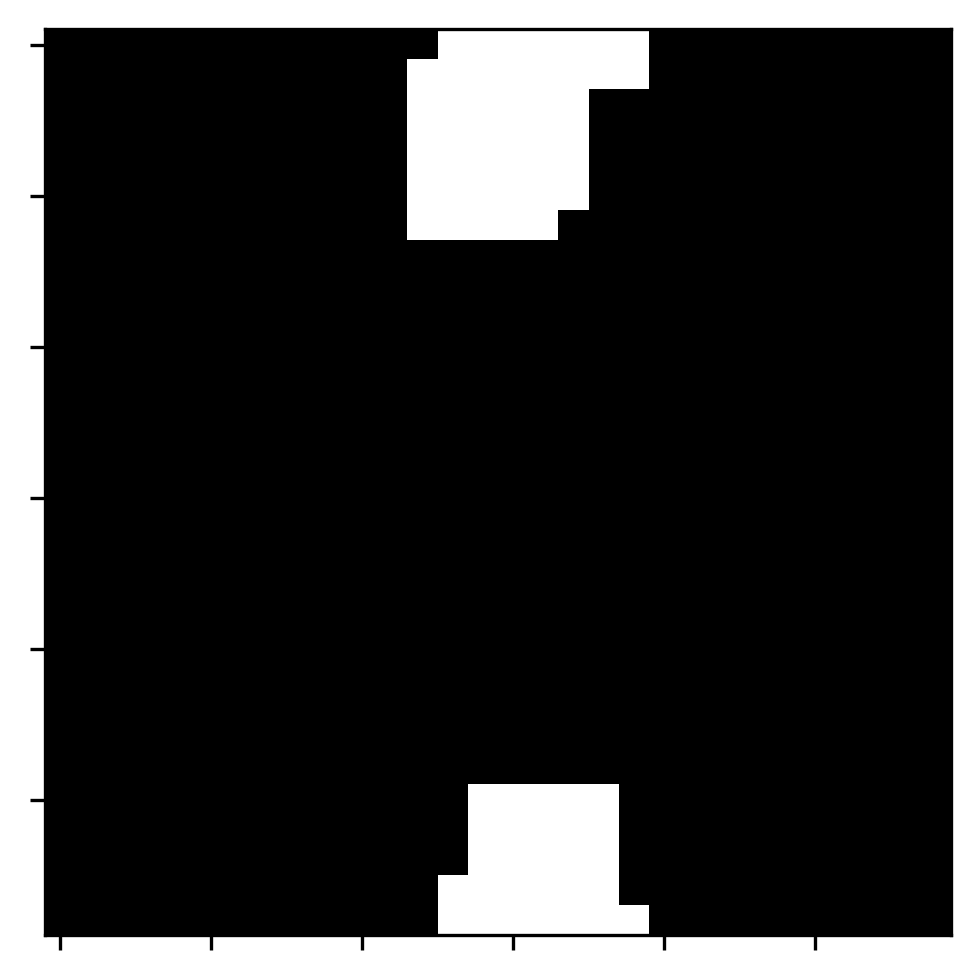

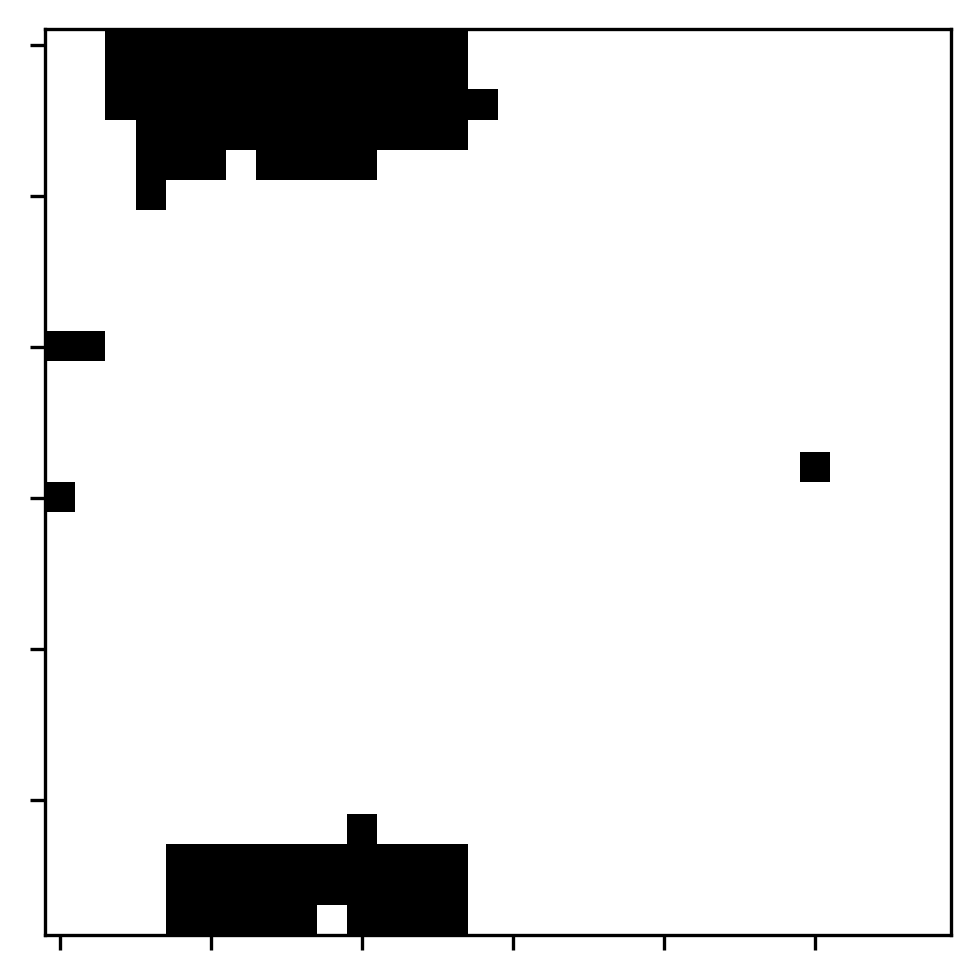

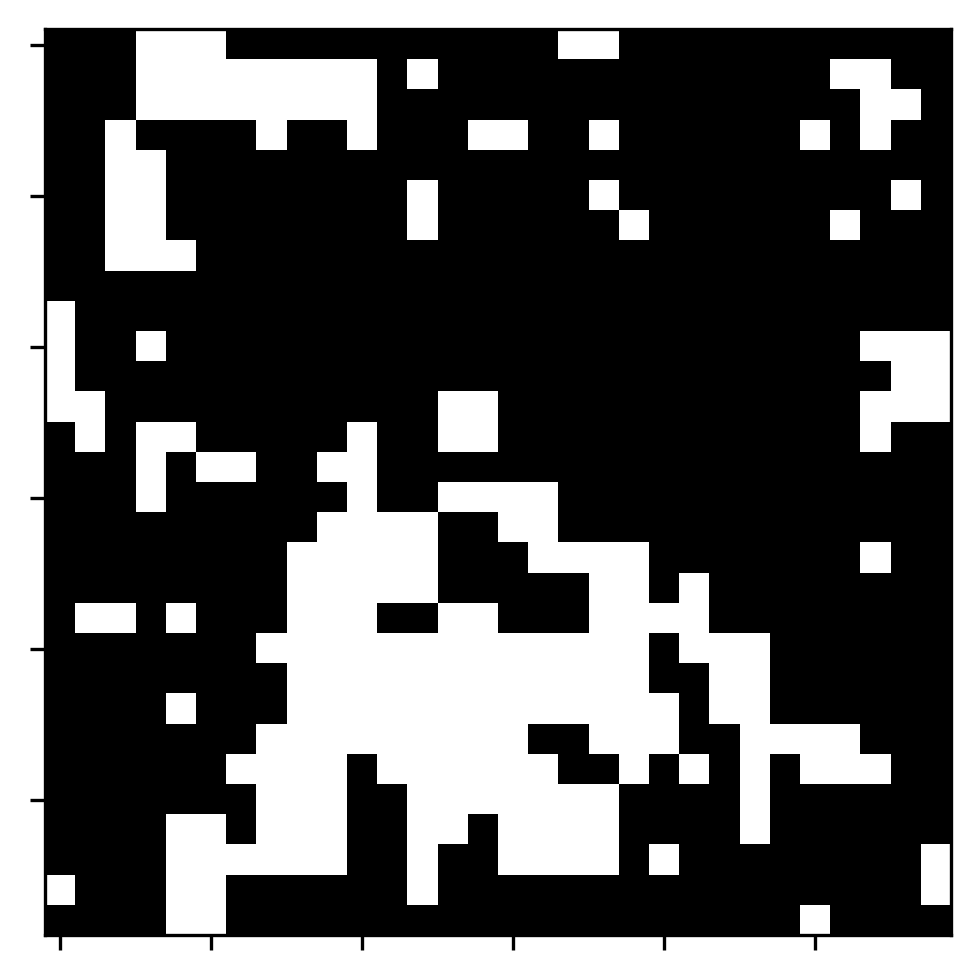

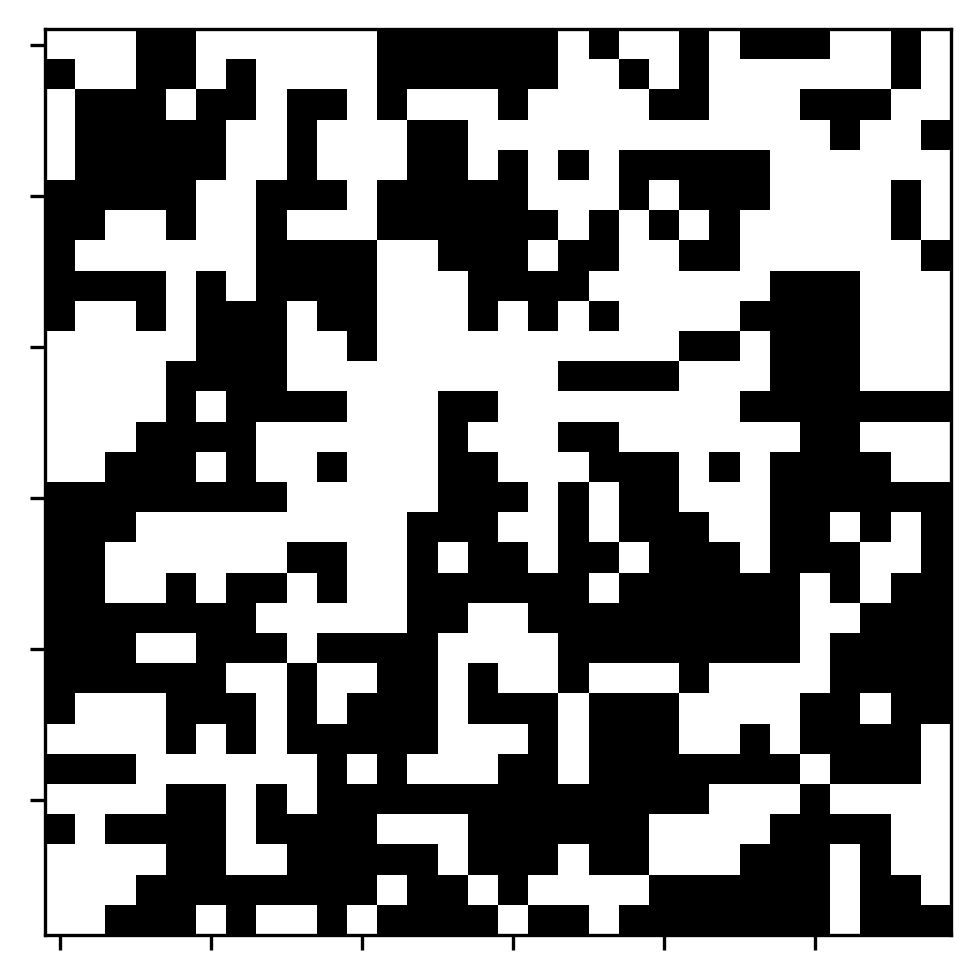

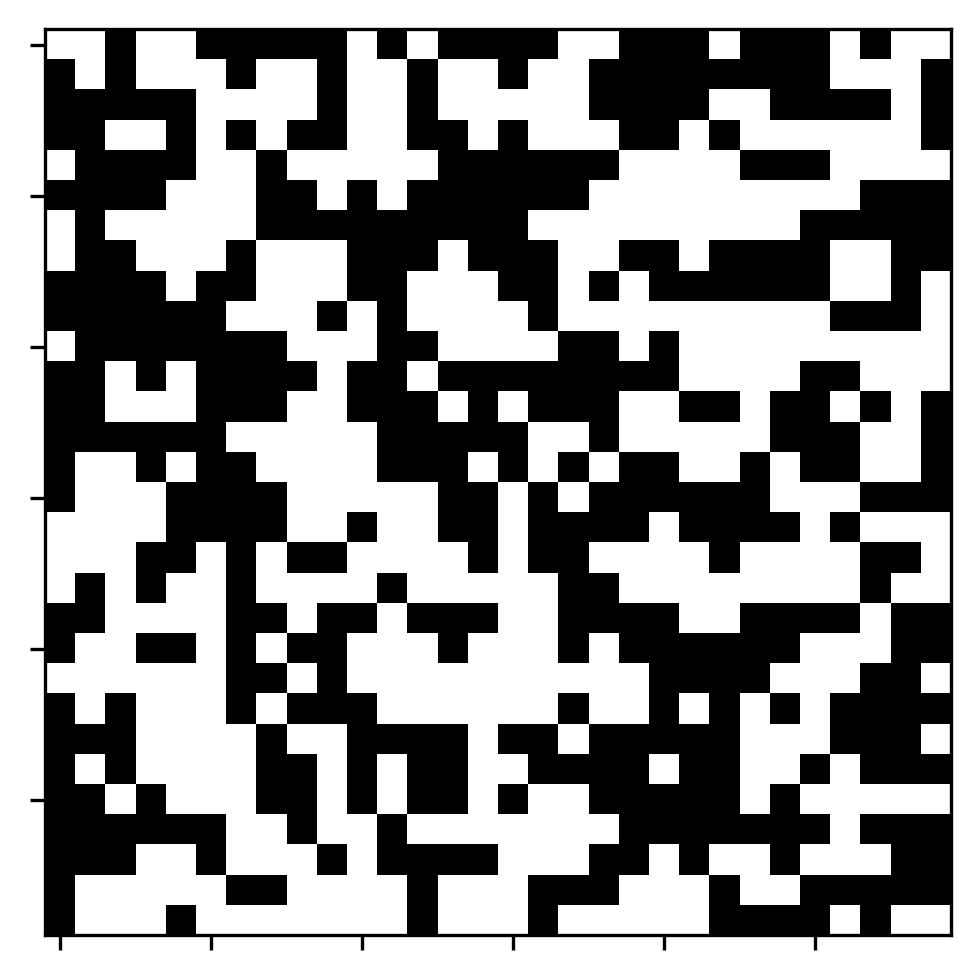

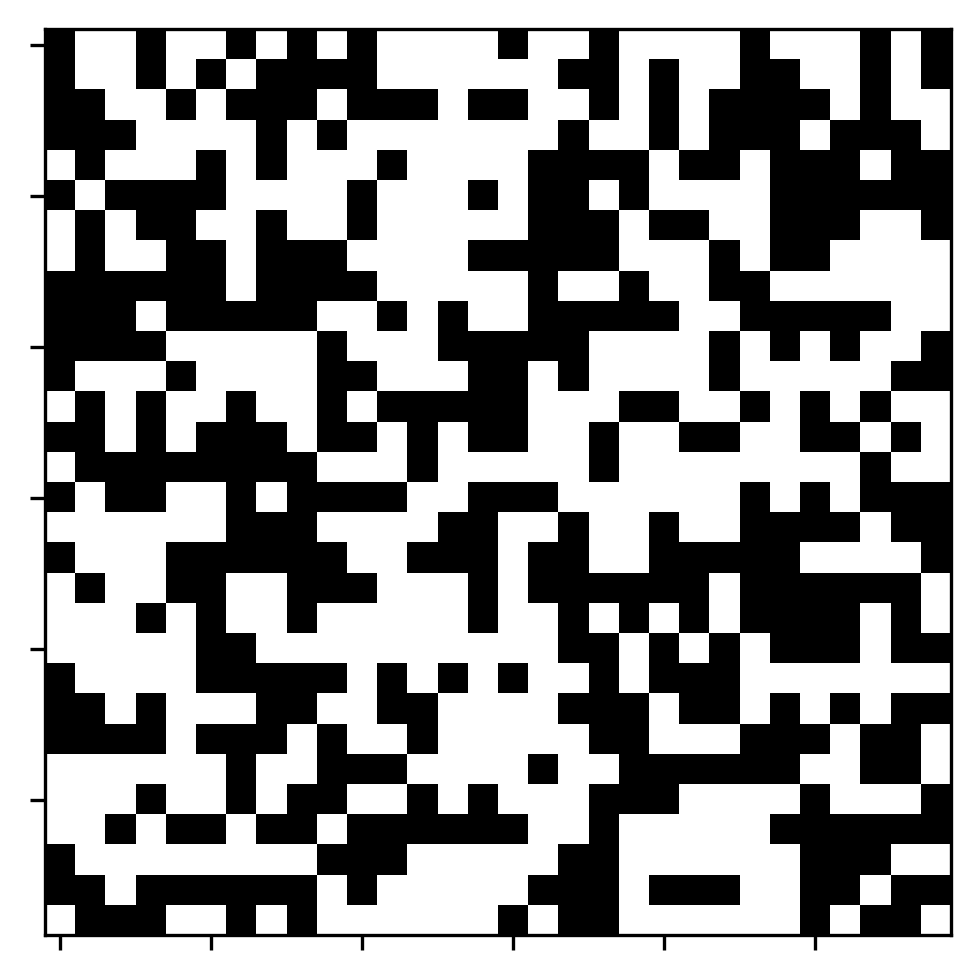

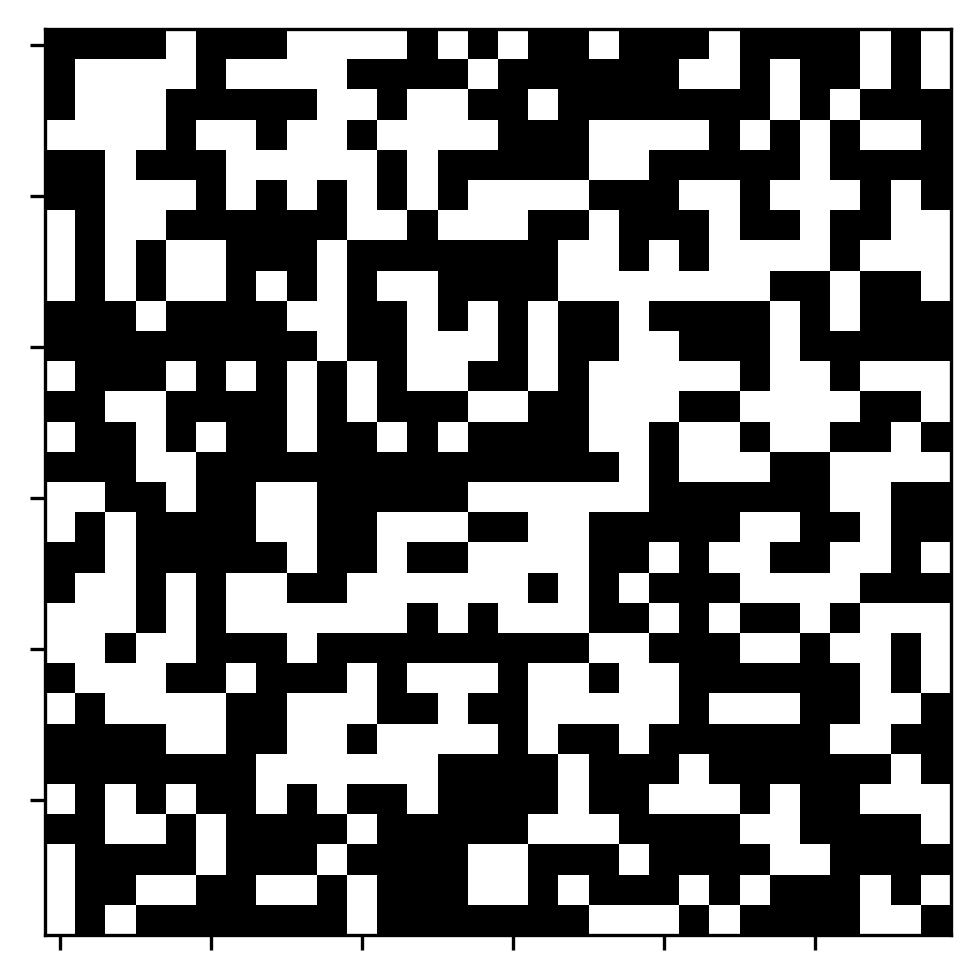

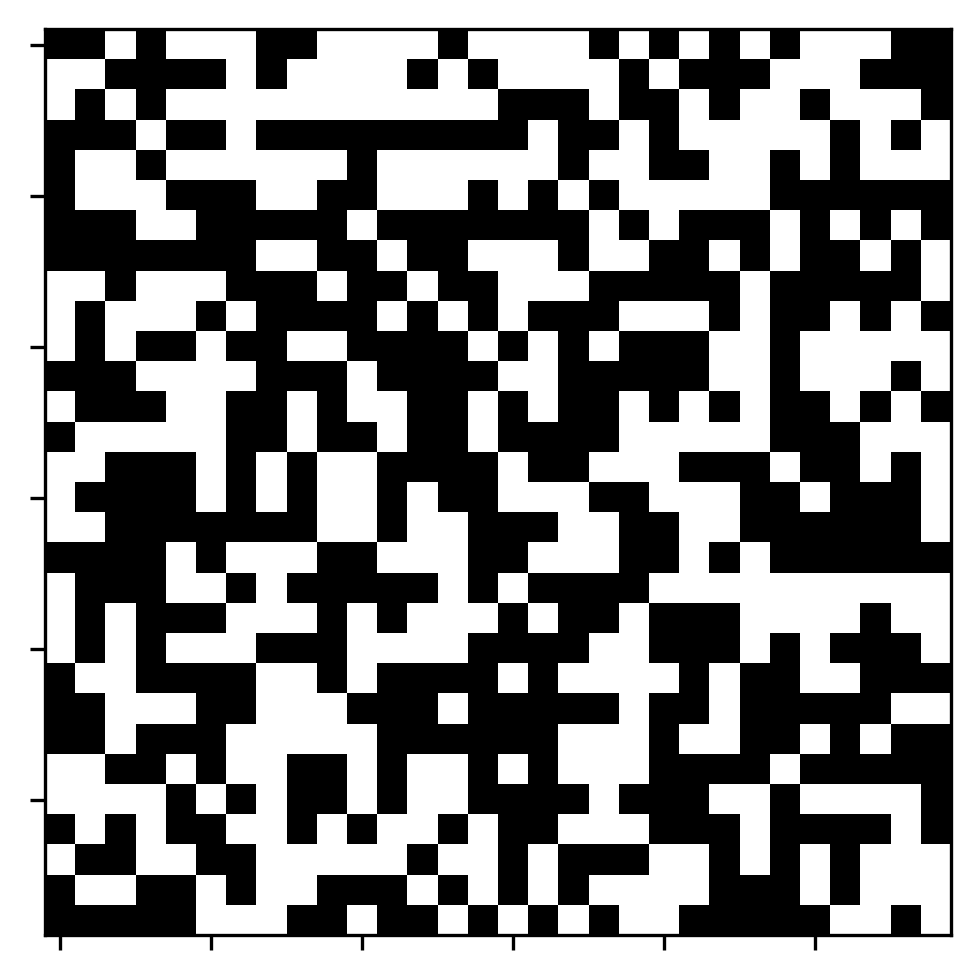

In [14]:
nTemps=10
tempArray=np.logspace(-0.5,1.5,nTemps)
energyArray=np.zeros(nTemps)
magArray=np.zeros(nTemps)

for ti in tqdm(range(len(tempArray))):
    spins=init_spins()
    T=tempArray[ti]
    J=1
    steps=100000
    energy=get_energy(spins,J)
    energies=np.zeros(steps)
    mags=np.zeros(steps)
    for step in range(steps):
        spins,energy=mcmh_step(spins,energy,T, J)
        energies[step]=energy
        mags[step]=np.average(spins)
    energyArray[ti]=energies[-1]
    magArray[ti]=mags[-1]
    fig,ax=plt.subplots()
    ax.imshow(spins,cmap='binary')
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])

[ 0.31622777  0.52749971  0.87992254  1.46779927  2.44843675  4.08423865
  6.81292069 11.36463666 18.95735652 31.6227766 ]


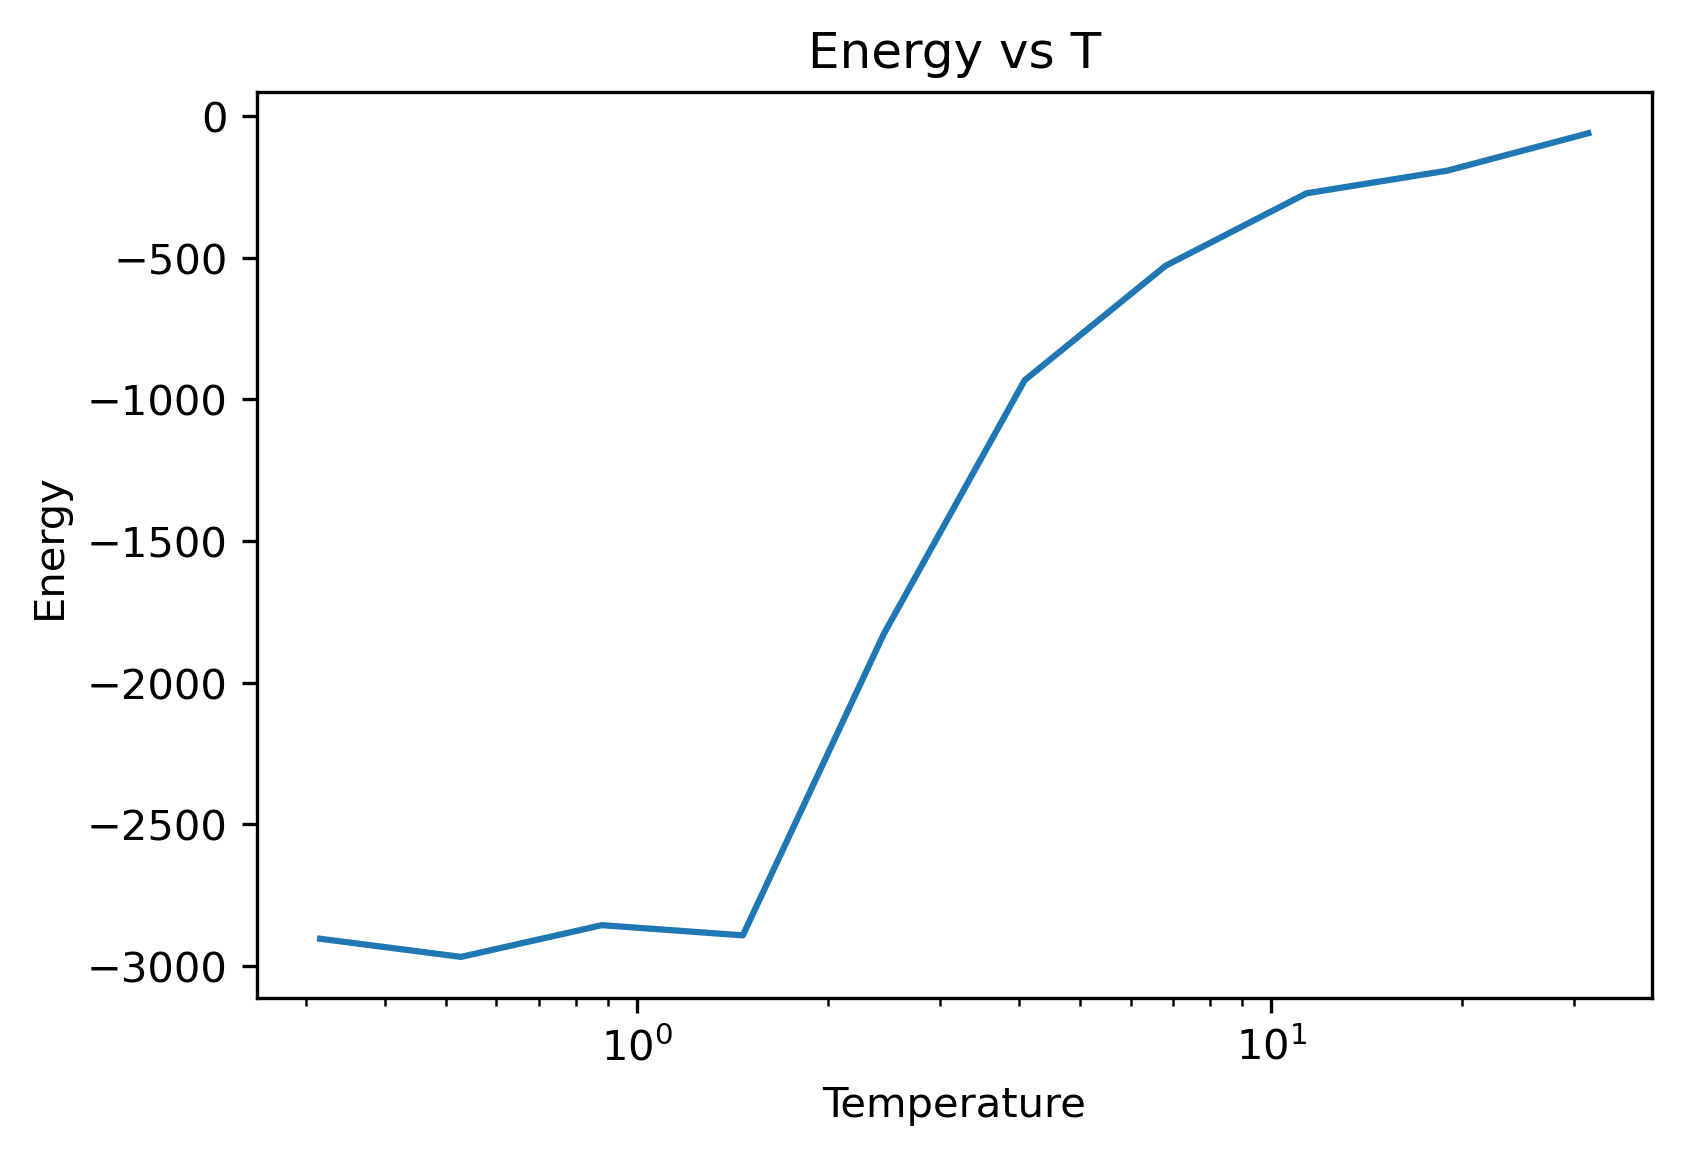

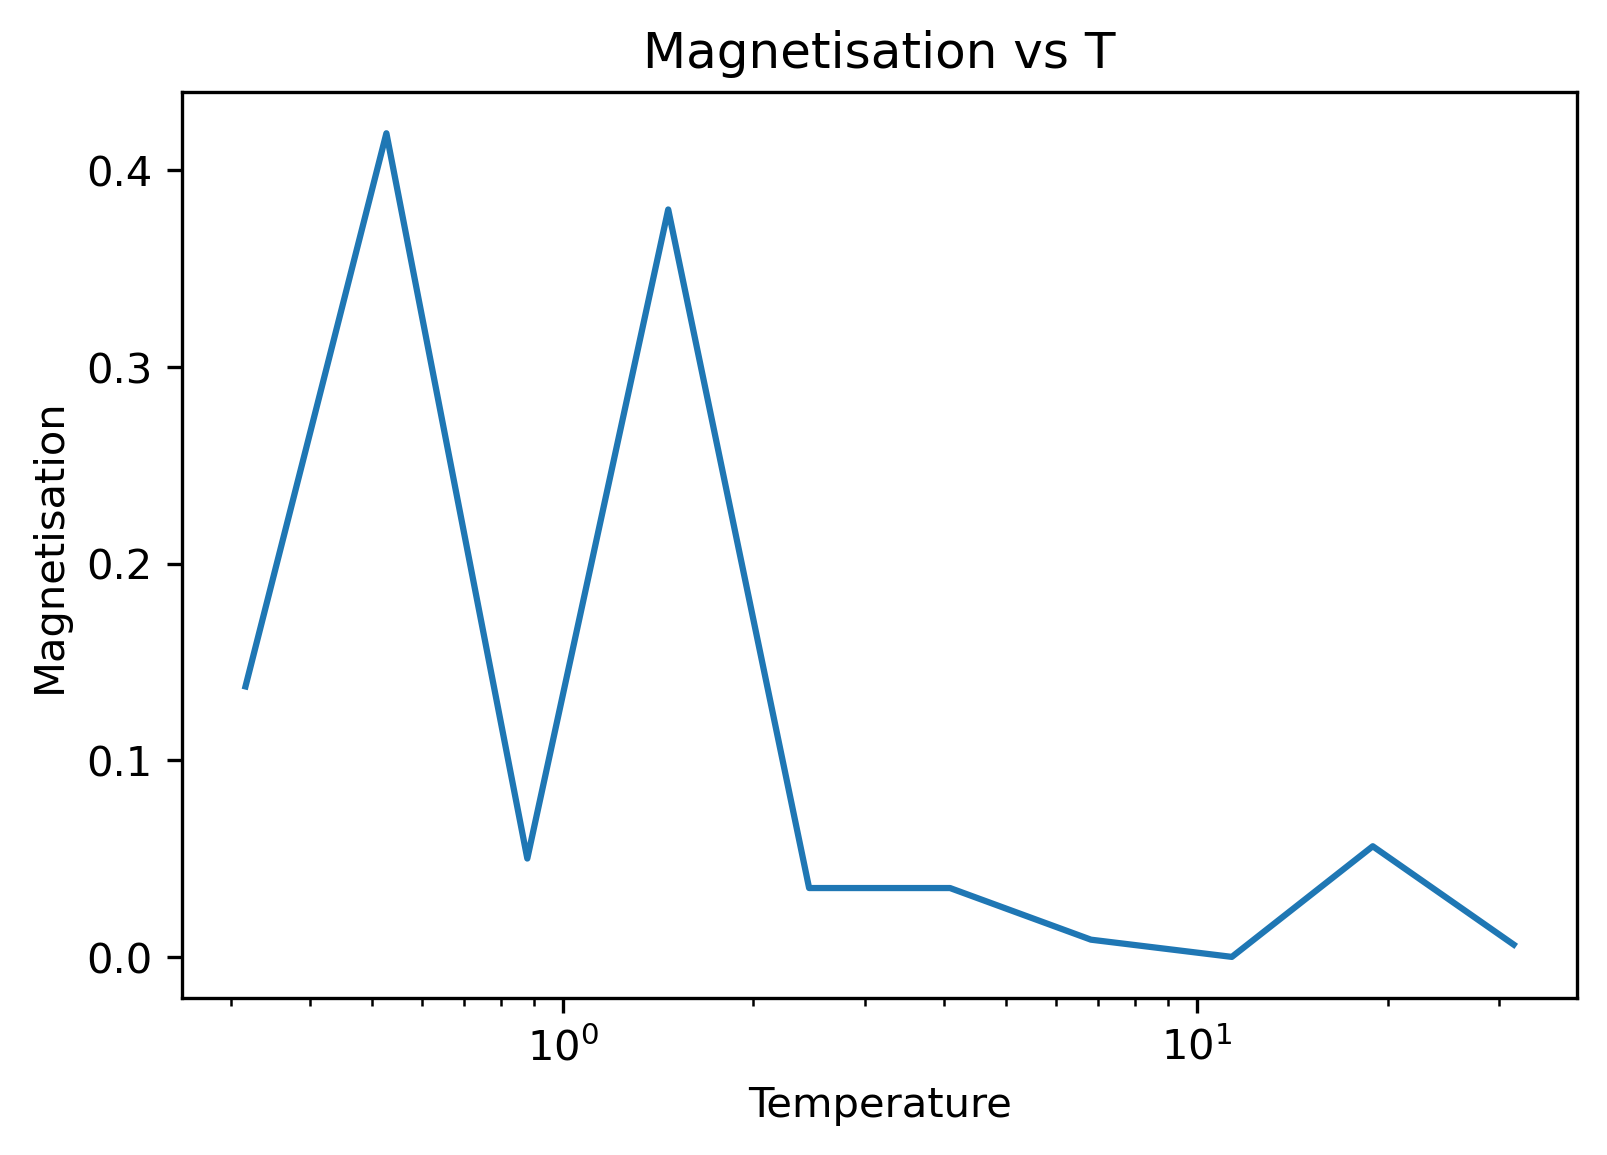

In [11]:
fig,ax=plt.subplots()
ax.plot(tempArray,energyArray)
ax.set_xlabel("Temperature")
ax.set_ylabel("Energy")
ax.set_title("Energy vs T")
ax.set_xscale("log")

fig,ax=plt.subplots()
ax.plot(tempArray,np.abs(magArray))
ax.set_xlabel("Temperature")
ax.set_ylabel("Magnetisation")
ax.set_title("Magnetisation vs T")
ax.set_xscale("log")
print(tempArray)

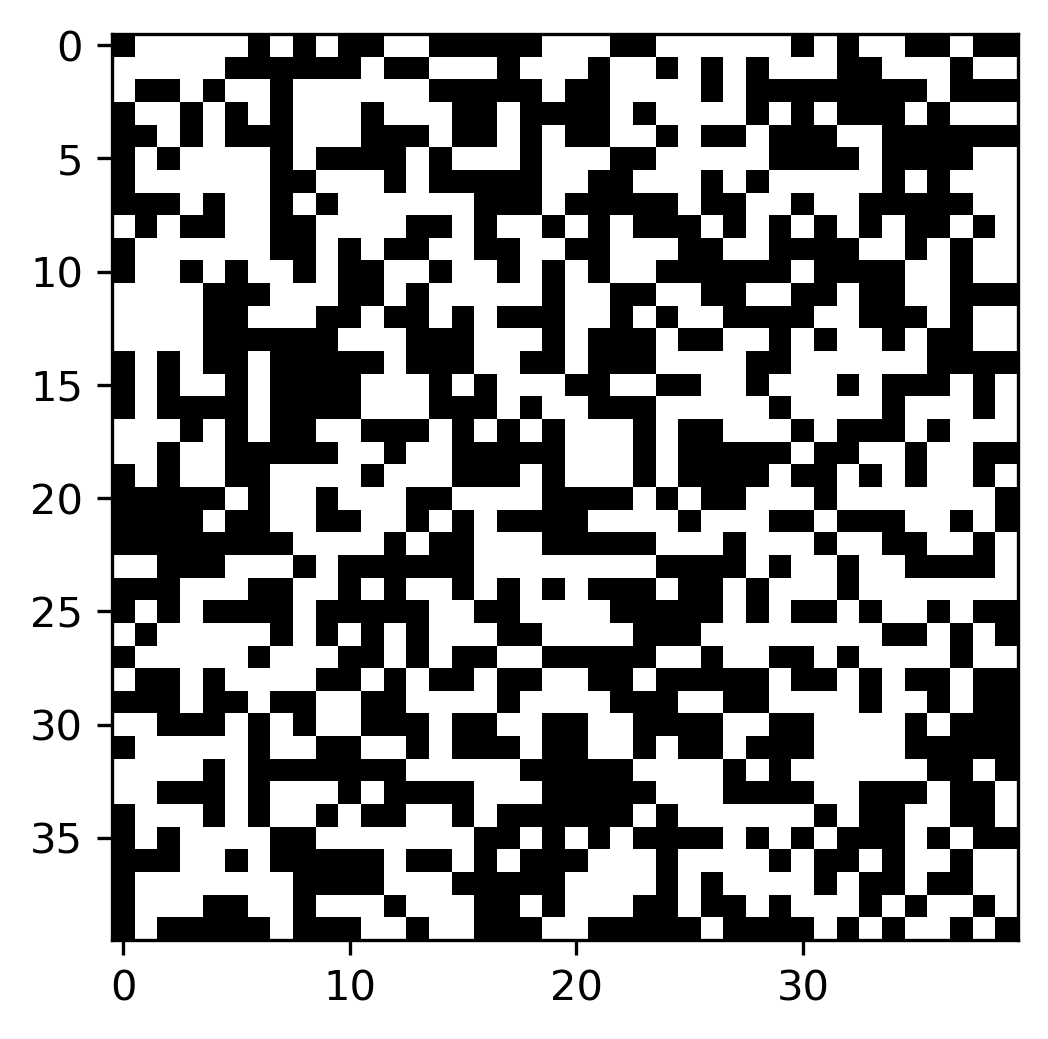

In [12]:
fig,ax=plt.subplots()
ax.imshow(spins,cmap='binary')